In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
from fbprophet import Prophet
import dateparser
import pmdarima as pm

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

Importing plotly failed. Interactive plots will not work.


In [2]:
train = pd.read_csv("Train.csv")
train['Datetime'] = pd.to_datetime(train['Datetime'], format = '%d-%m-%Y %H:%M')
train['Date'] = train["Datetime"].dt.date
train = train.groupby(['Date'])['Count'].sum().reset_index()
train = train.set_index('Date')
train.head(5)

,Count
Date,
2012-08-25,76
2012-08-26,88
2012-08-27,62
2012-08-28,58
2012-08-29,60


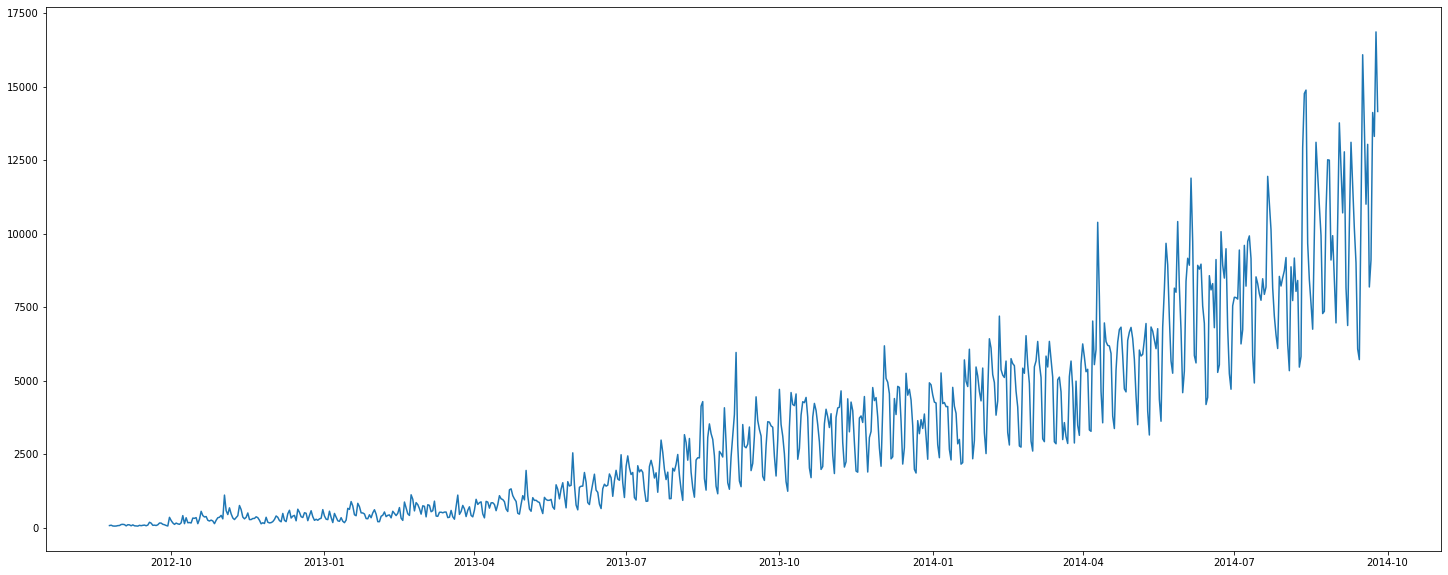

In [3]:
plt.figure(figsize=(25,10))
plt.plot(train.index, train.Count)

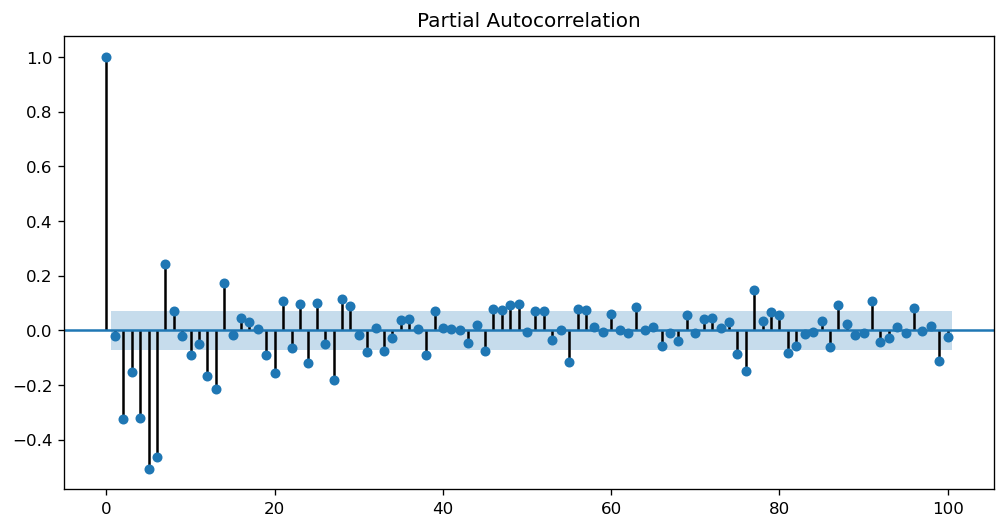

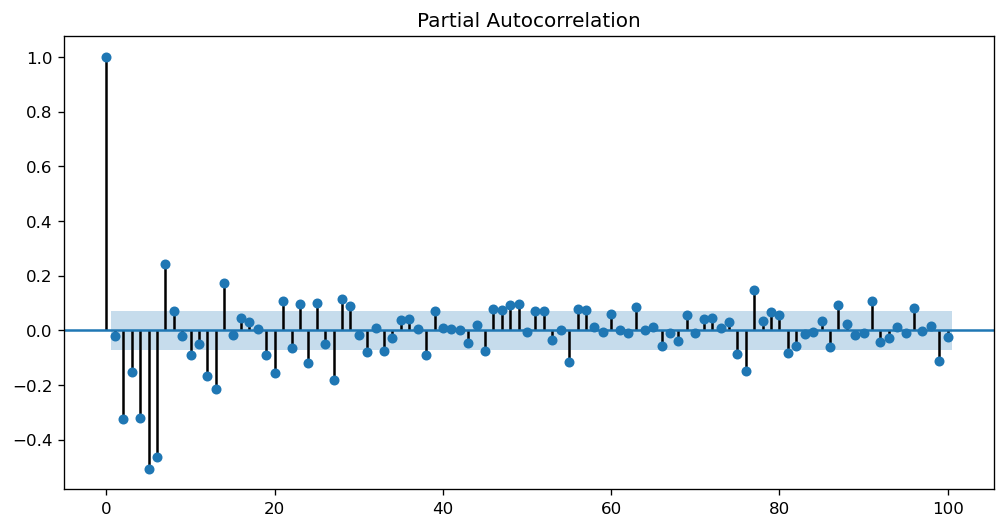

In [4]:
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
plot_pacf(train.Count.diff().dropna(), lags=100)

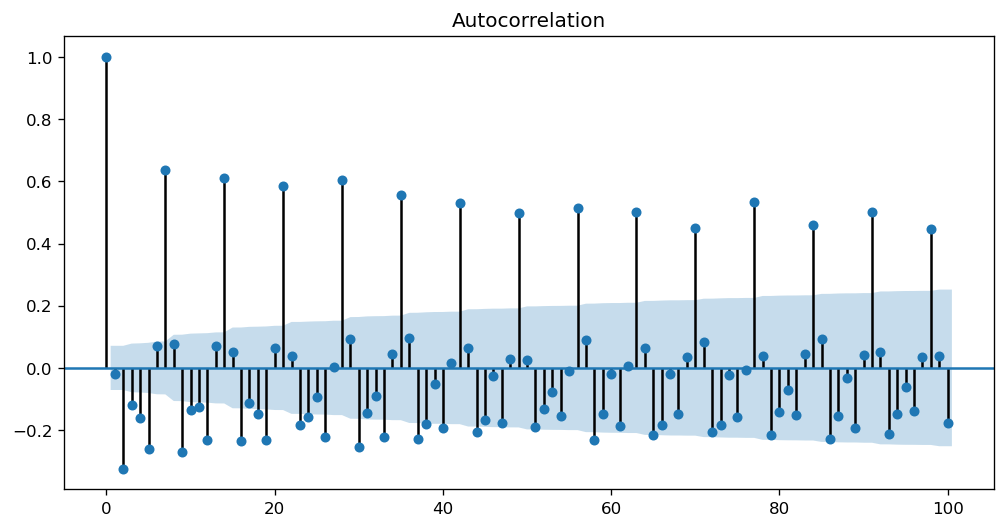

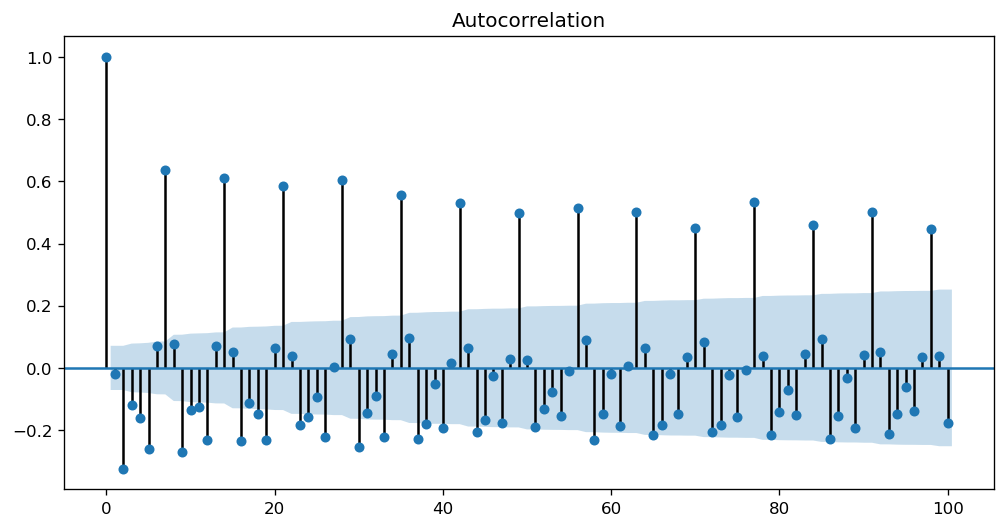

In [5]:
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
plot_acf(train.Count.diff().dropna(), lags=100)

<ipython-input-6-64532a722fe9>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  sm.tsa.seasonal_decompose(train.Count, freq=24).plot()


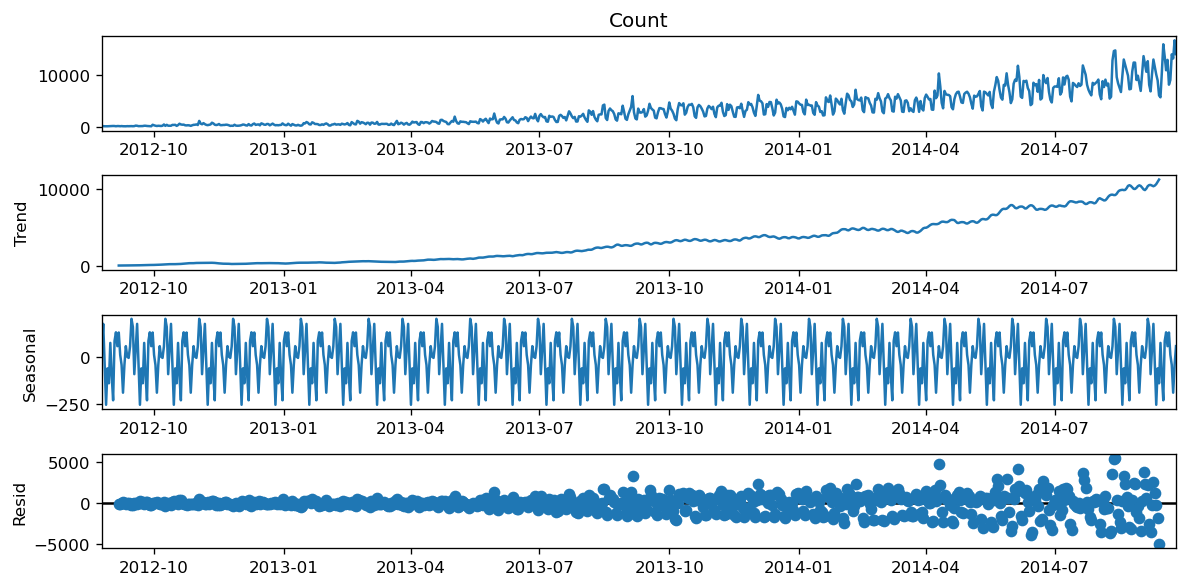

In [6]:
sm.tsa.seasonal_decompose(train.Count, freq=24).plot()
result = sm.tsa.stattools.adfuller(train.Count)
plt.show()

In [7]:
X = train.values
train_df = X[0:535]
test_df = X[535:]
predictions = []

import itertools
from tqdm.notebook import tqdm
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

param_aic_seasonal = {}
for param in tqdm(pdq):
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statspace.SARIMAX(train,
                                          order = param,
                                          seasonal_order = param_seasonal)
            
            results = mod.fit()
            param_aic_seasonal[param, param_seasonal] =results.aic
        
        except:
            continue

In [8]:
{k: v for k, v in sorted(param_aic_seasonal.items(), key = lambda item:item[1])}

{}

In [9]:
mod = sm.tsa.statespace.SARIMAX(train_df, order = (0, 1, 2), seasonal_order = (0, 2, 2, 7))
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  535
Model:             SARIMAX(0, 1, 2)x(0, 2, 2, 7)   Log Likelihood               -3893.465
Date:                           Sun, 22 Nov 2020   AIC                           7796.931
Time:                                   22:17:50   BIC                           7818.200
Sample:                                        0   HQIC                          7805.263
                                           - 535                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5797      0.029    -19.663      0.000      -0.637      -0.522
ma.L2         -0.2894      0.033     -8.767

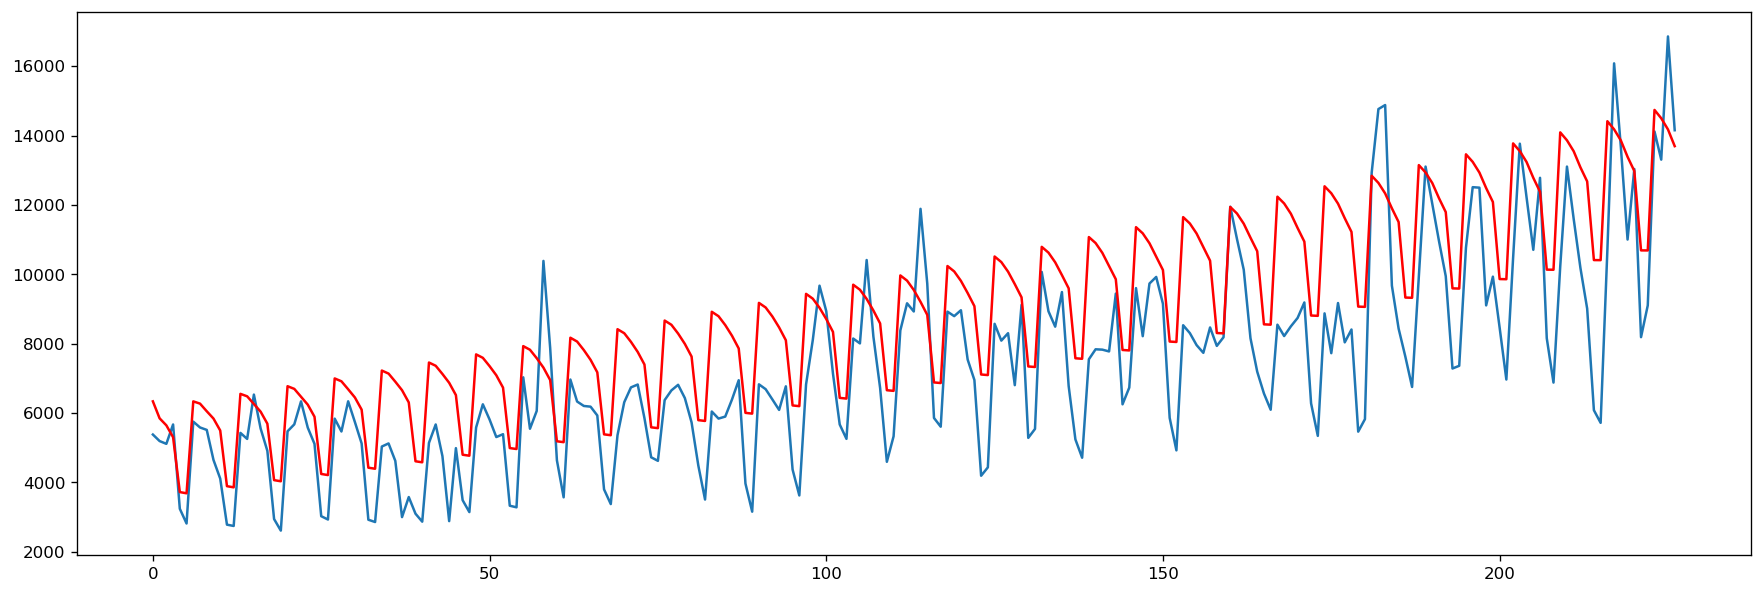

2013332.9299111024


In [10]:
y_pred = results.predict(start = 535, end = 761, dynamic = True)
rcParams['figure.figsize'] = 18, 6
plt.plot(test_df)
plt.plot(y_pred, color ='red')
plt.show()
print(y_pred.sum())

In [11]:
train_data = train[:]

mod = sm.tsa.statespace.SARIMAX(train_data['Count'], order=(0, 1, 2), seasonal_order=(0, 2, 2, 7))
results = mod.fit()
print(results.summary())

y_new = results.predict(start = 762, end = 974, dynamic = True)
y_old = results.predict(start = 0, end = 761, dynamic = True )
print(y_new.sum())

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                     
Dep. Variable:                             Count   No. Observations:                  762
Model:             SARIMAX(0, 1, 2)x(0, 2, 2, 7)   Log Likelihood               -5976.453
Date:                           Sun, 22 Nov 2020   AIC                          11962.905
Time:                                   22:17:56   BIC                          11985.986
Sample:                               08-25-2012   HQIC                         11971.800
                                    - 09-25-2014                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4725      0.024    -19.799      0.000      -0.519      -0.426
ma.L2         -0.4178      0.022    -19.322

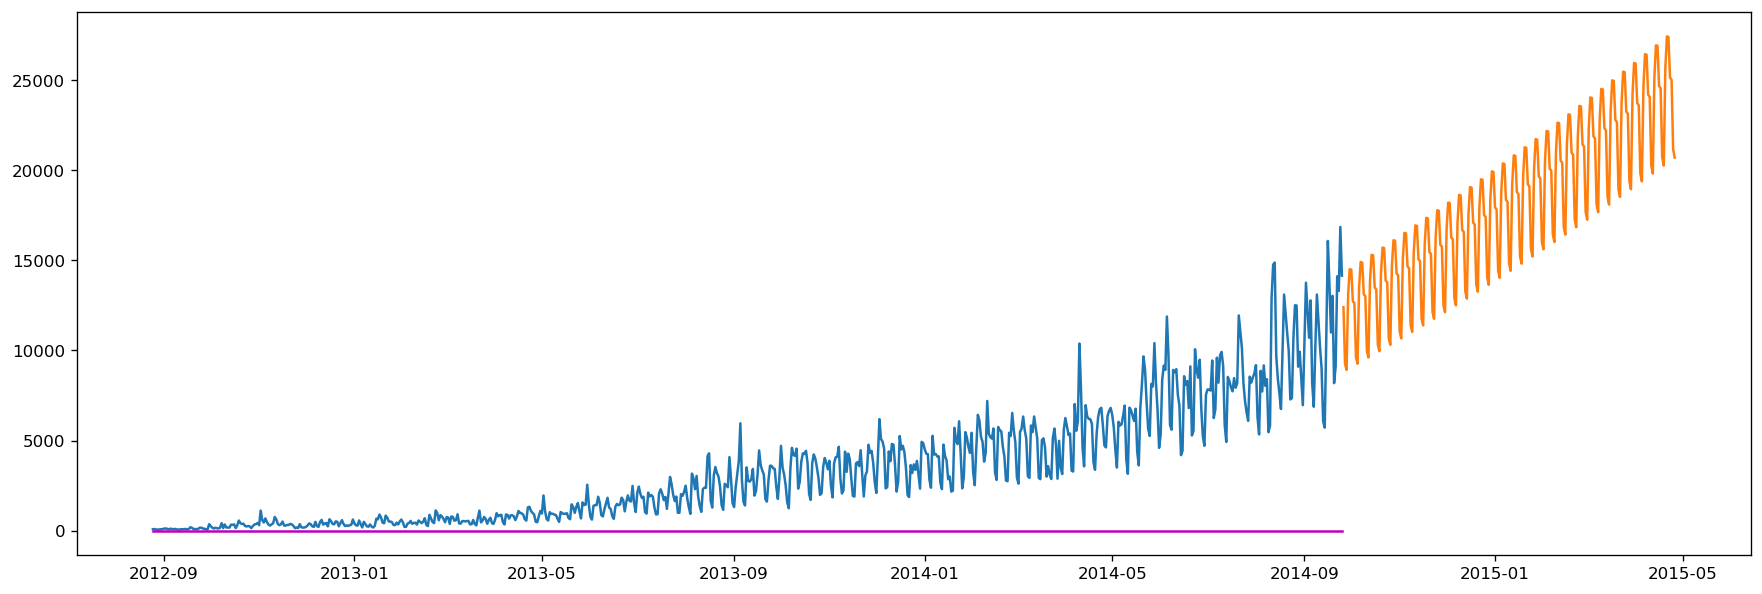

In [12]:
plt.plot(train.index, train['Count'])
plt.plot(y_new.index, y_new)
plt.plot(y_old.index, y_old, 'm')
plt.show()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.


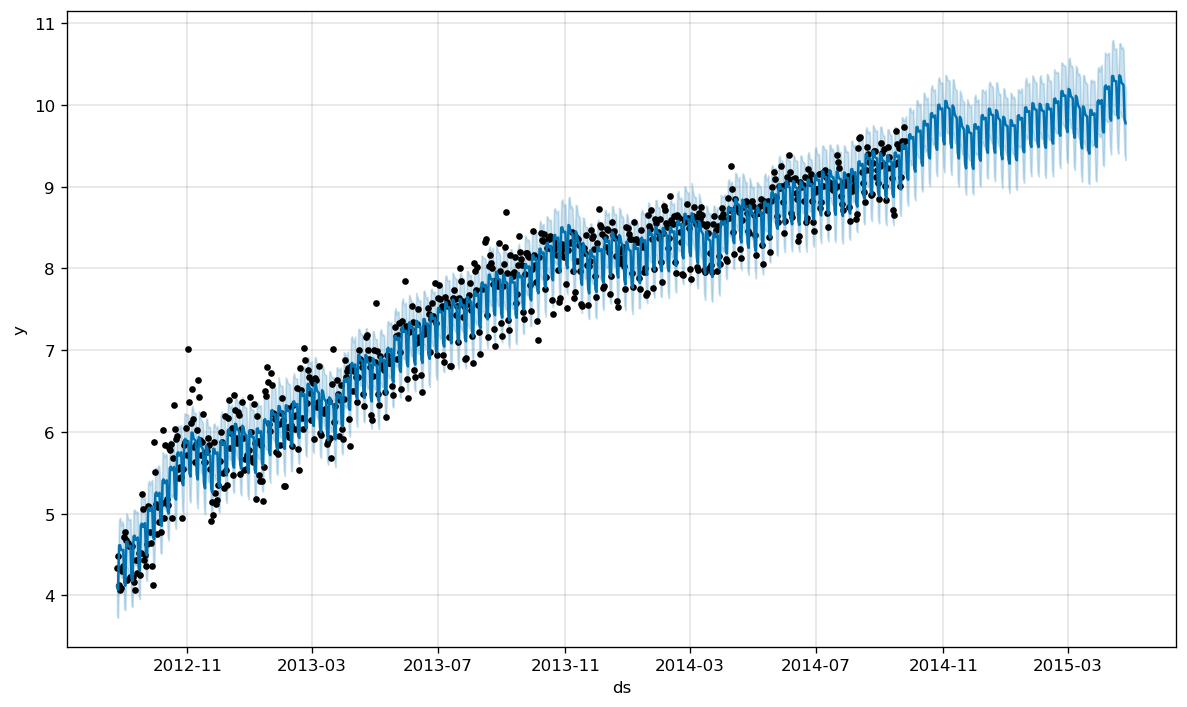

In [13]:
train = pd.read_csv('Train.csv')
train['Datetime'] = pd.to_datetime(train['Datetime'], format = '%d-%m-%Y %H:%M')
train['Date'] = train["Datetime"].dt.date
train = train.groupby(['Date'])['Count'].sum().reset_index()
train.columns = ['ds', 'y']
train['y'] = np.log(train['y'])
model = Prophet(daily_seasonality=False)
model.add_seasonality(name='weekly', period =7, fourier_order=300)
model.fit(train)
future = model.make_future_dataframe(periods=213)
forecast = model.predict(future)
fig1 = model.plot(forecast)

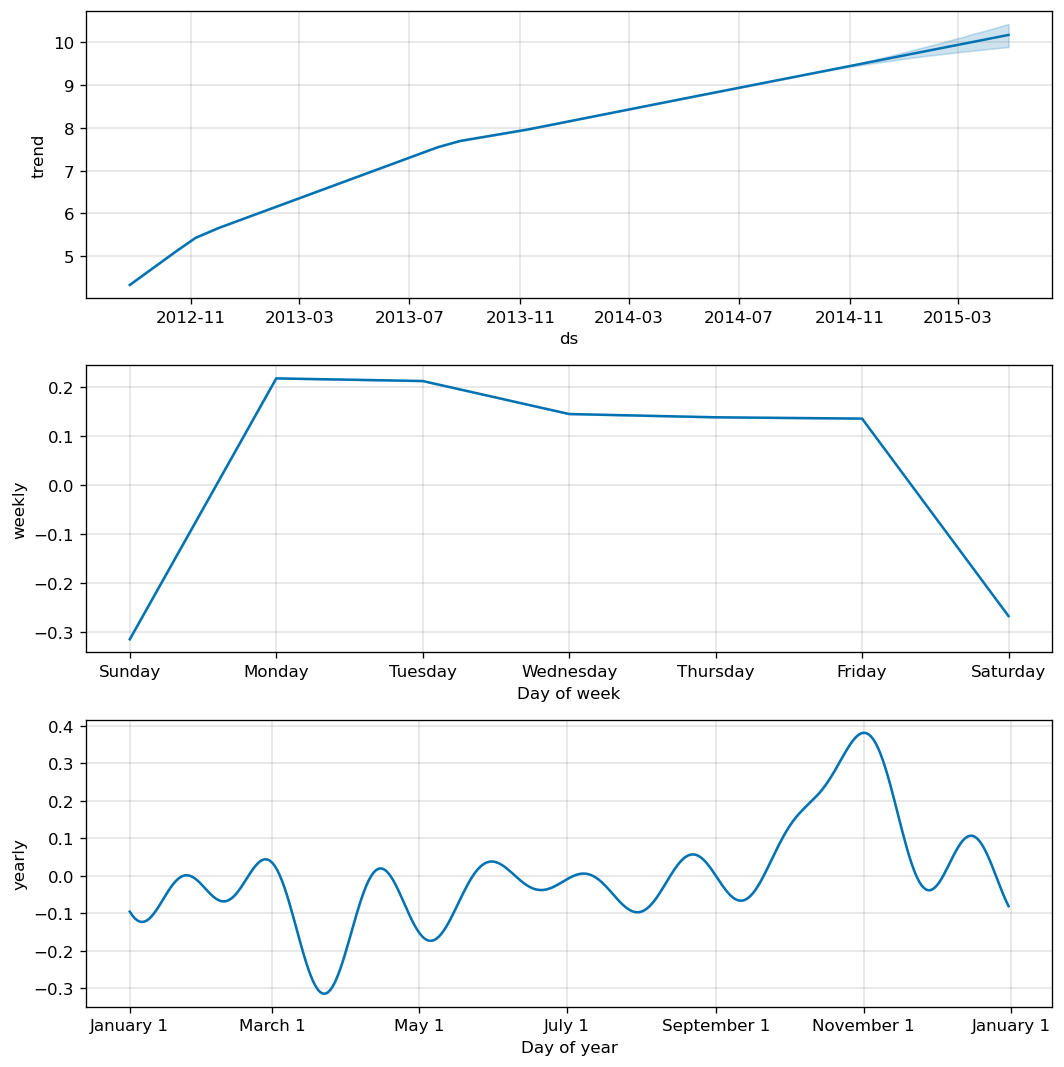

In [14]:
fig2 = model.plot_components(forecast)

In [17]:
f_preds = np.exp(forecast[-213:]['yhat']).values
er = []
listm = [0.044286588, 0.035343014, 0.029911076, 0.024714453, 0.02080223, 0.018621427, 
         0.020023091, 0.023221497, 0.026741002, 0.034555218, 0.049047207, 0.05437526, 
         0.054951351, 0.048600186, 0.051965438, 0.051309072, 0.049999488, 0.051164262, 
         0.052423477, 0.055626605, 0.053455246, 0.049894816, 0.050075828, 0.048892166]

for p in range(len(f_preds)):
    for l in range(len(listm)):
        er.append(f_preds[p]*listm[l])

result = {'Count':er}
submission_df = pd.DataFrame({
                    'ID': pd.Series([x+18288 for x in range(5112)]),
                    'Count': pd.Series(result['Count'])})
submission_df.to_csv('submission_test_fb.csv', index=False)

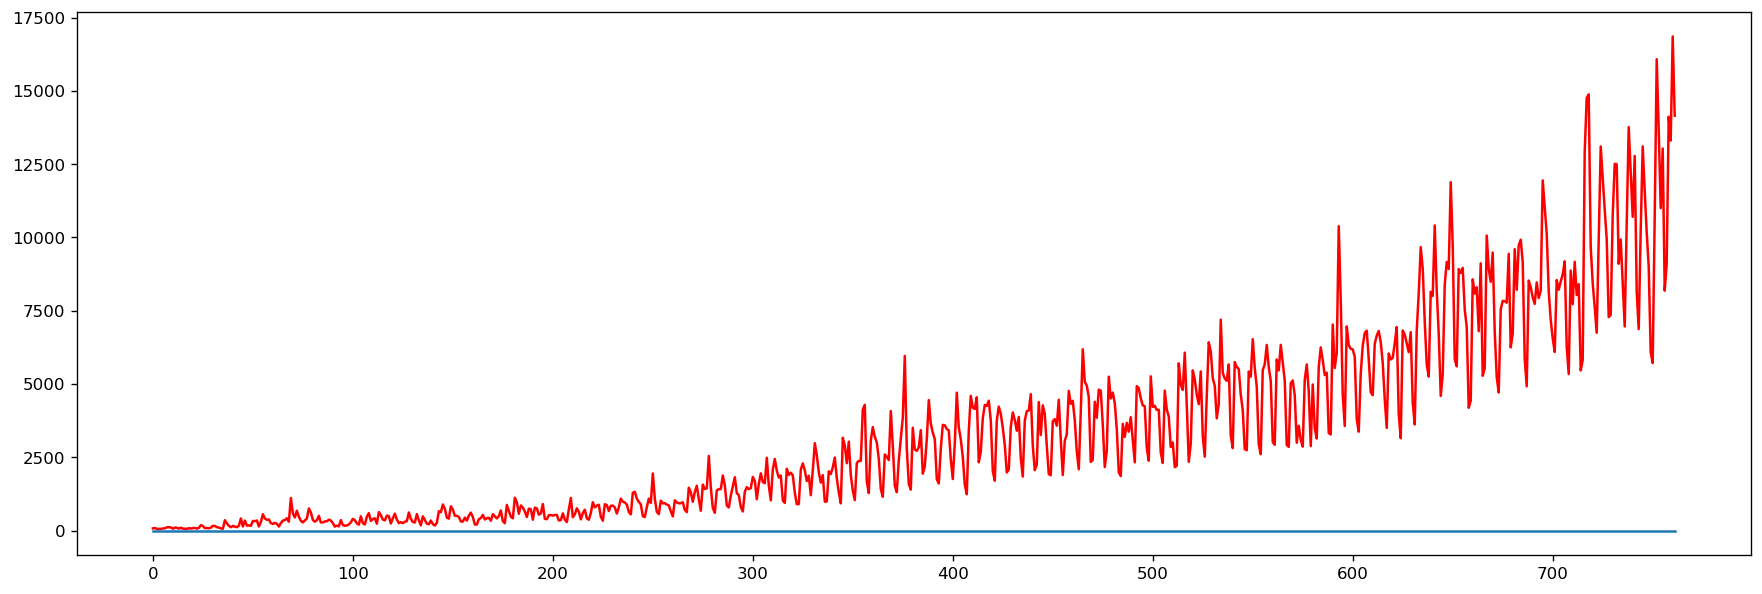

In [29]:
y_old_df = y_old.reset_index(name = 'Count')
y_new_df = y_new.reset_index(name = 'Count')
plt.plot(range(0, len(y_old_df)), train_data['Count'], color='red')
plt.plot(range(0, len(y_old_df)), y_old_df['Count'])

In [36]:
df = pd.read_csv('Train.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y %H:%M')
df['date'] = df['Datetime'].dt.date
df = df.groupby(['date'])['Count'].sum().reset_index()
df['date'] = pd.to_datetime(df['date'])
df['month'] = df.date.dt.month
df['day'] = df.date.dt.weekday
df['month_start'] = df.date.apply(lambda x: 1 if x.is_month_start else 0)
df['month_end'] = df.date.apply(lambda x: 1 if x.is_month_end else 0)
df['week_start'] = df.day.apply(lambda x: 1 if x==0 or x ==1 else 0)
df['week_end'] = df.day.apply(lambda x: 1 if x==5 or x==6 else 0)
df['month_day'] = df.date.dt.day
df['predicted'] = y_old_df['Count']
df['diff'] = df.date.apply(lambda x: (x-dateparser.parse('2012-08-25')).days)
df.head()

,date,Count,month,day,month_start,month_end,week_start,week_end,month_day,predicted,diff
0,2012-08-25,76,8,5,0,0,0,1,25,0.0,0
1,2012-08-26,88,8,6,0,0,0,1,26,0.0,1
2,2012-08-27,62,8,0,0,0,1,0,27,0.0,2
3,2012-08-28,58,8,1,0,0,1,0,28,0.0,3
4,2012-08-29,60,8,2,0,0,0,0,29,0.0,4


In [38]:
dfh = df.groupby(['date'])['Count'].sum().reset_index()
dfh.sort_values(['Count'], ascending = [False]).head()

,date,Count
760,2014-09-24,16856
752,2014-09-16,16080
718,2014-08-13,14878
717,2014-08-12,14762
761,2014-09-25,14152


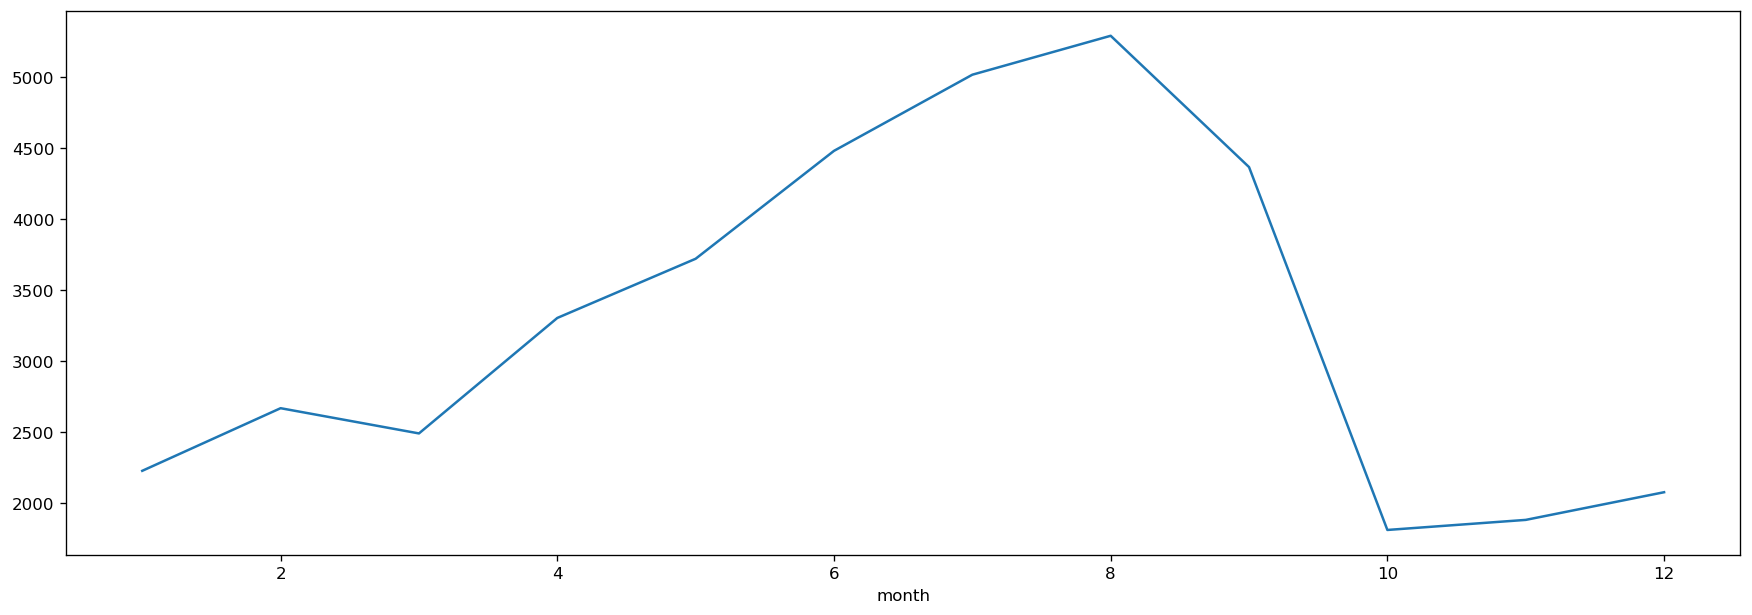

In [39]:
df.groupby(['month'])['Count'].mean().plot()

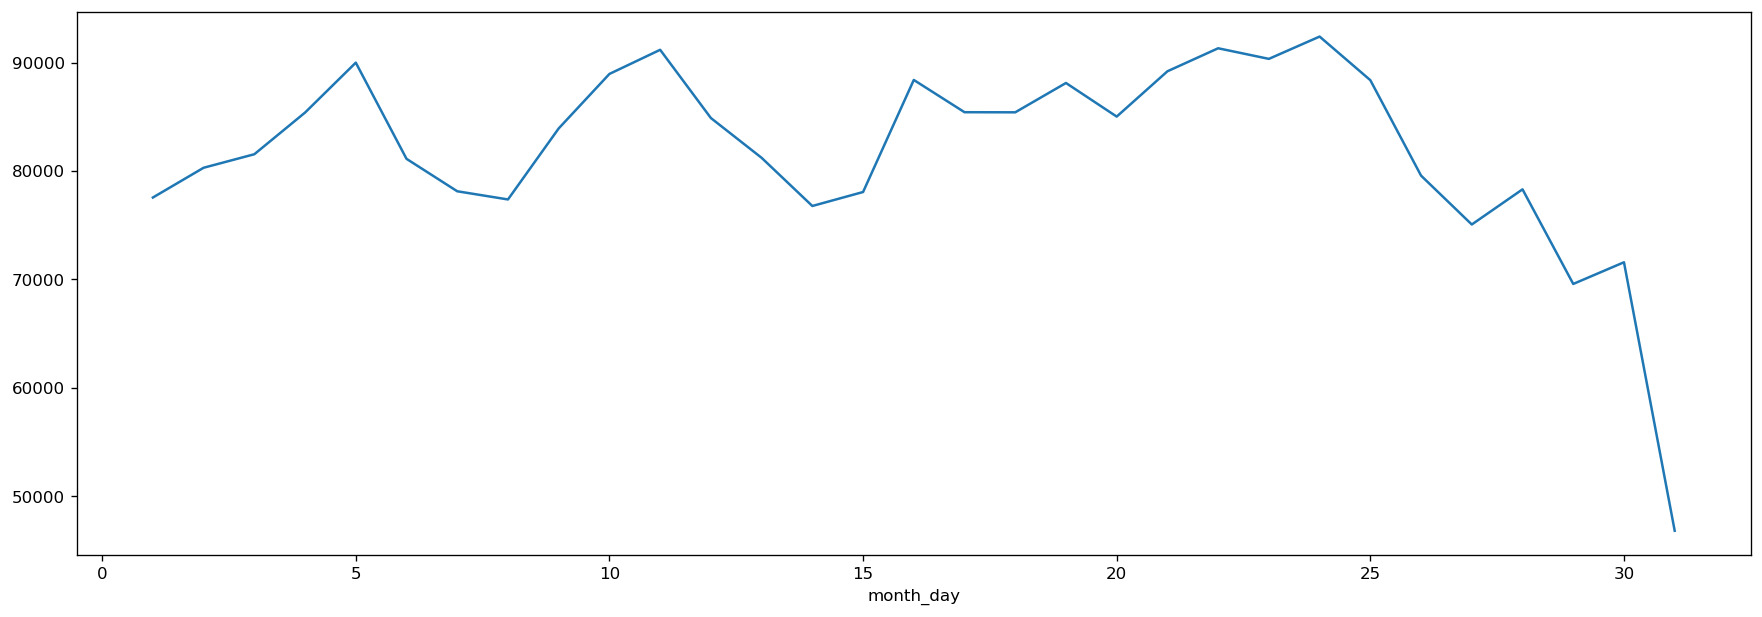

In [40]:
df.groupby(['month_day'])['Count'].sum().plot()

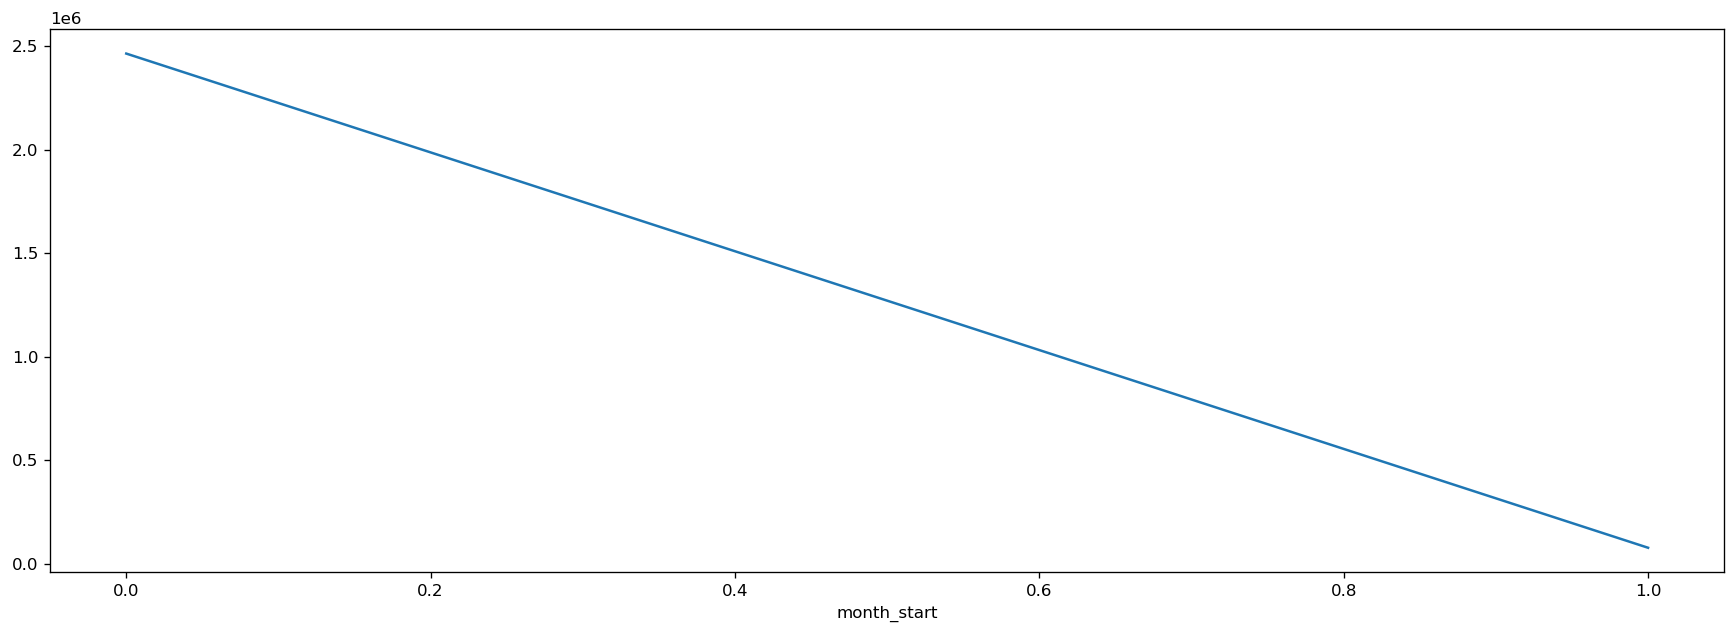

In [41]:
df.groupby(['month_start'])['Count'].sum().plot()